In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
from jax import random
from jax.api import jit, grad, vmap
from jax.experimental import optimizers
from jax import device_put
import timeit
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
import scipy as sp
import scipy.special
import scipy.sparse
import math
import tensorflow as tf
import sys
import sklearn
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax

In [0]:
# process the data for fully connected (convert to grayscale)
def process_data(batch_block):
  image, label = batch_block['image'], batch_block['label']
  samples = image.shape[0]
  image = tf.image.rgb_to_grayscale(image).numpy()
  image = jnp.reshape(image, (image.shape[0], 32*32))
  image = jnp.array(image, dtype = np.float32)
  label = jnp.eye(100)[label]
  return {'image': image, 'label': label}

# process data for convolutional NTK
def process_data_conv(batch_block):
  image, label = batch_block['image'], batch_block['label']
  image = tf.image.rgb_to_grayscale(image).numpy()
  samples = image.shape[0]
  image = jnp.array(image, dtype = np.float32)
  label = jnp.eye(100)[label]
  return {'image': image, 'label': label}

batch_size = 200
training_epochs = 5
test_data = tfds.load('cifar10', split=tfds.Split.TEST)
train_data = tfds.load('cifar100', split=tfds.Split.TRAIN)
train_data_shuff = tfds.as_numpy(
    train_data.shuffle(1024).batch(batch_size))
test_data_shuff = tfds.as_numpy(
    train_data.shuffle(1024).batch(batch_size))


In [0]:
# Formulae for fully connected ReLU NTK; Primitive expressions from Cho, Saul (2009)
# implemented in JAX to improve efficiency
def kernel_2_layer(z):
  return z*(1 - 1/math.pi*jnp.arccos(z)) + 1/math.pi * jnp.sqrt(1-z**2)

def f(phi, L):
    if L==1:
        return jnp.arccos(1/math.pi * jnp.sin(phi) + (1 - 1/math.pi *  jnp.arccos(jnp.cos(phi))   )   * jnp.cos(phi))
    elif L==0:
        return jnp.arccos(jnp.cos(phi))
    else:
        return f(phi,L-1)
    
def kernel(z, layers):
  if layers == 1:
    return kernel_2_layer(z)
  
  else:
    a = jnp.arccos(z)
    for i in range(layers-1):
      a = f(a,1)
    return jnp.cos(f(a,1)) + kernel(z,layers-1) * (1-a/math.pi) 


In [0]:
# load in data as matrices
M = 1000
train_blocks = tfds.as_numpy(train_data.shuffle(1024).batch(M))
test_blocks = tfds.as_numpy(train_data.shuffle(1024).batch(M))


all_data = np.zeros((50000, 1024))
all_labels = np.zeros((50000, 100))
all_test_data = np.zeros((50000, 1024))
all_test_labels = np.zeros((50000, 100))

for i, batch in enumerate(train_blocks):
  data = process_data(batch)
  image = data['image']
  label = data['label']
  all_data[i*M:(i+1)*M,:] = image / np.outer(np.linalg.norm(image, axis = 1), (1+1e-3)*np.ones(image.shape[1]))
  all_labels[i*M:(i+1)*M,:] = label

for i, batch in enumerate(test_blocks):
  data = process_data(batch)
  image = data['image']
  label = data['label']
  all_test_data[i*M:(i+1)*M,:] = image / np.outer(np.linalg.norm(image, axis = 1), (1+1e-3)*np.ones(image.shape[1]))
  all_test_labels[i*M:(i+1)*M,:] = label





In [0]:
# X is batch x classes
def soft_max(X):
  exp = jnp.exp(X)
  normalize = jnp.sum(exp, axis = 1)
  return exp / jnp.outer(normalize, np.ones(exp.shape[1]) )

In [0]:

# full batch gradient descent updates on logistic loss
def train_full_batch(all_data, all_labels, block_size, k):

  X = all_data[0:block_size,:] 
  X = X / ((1+1e-6)*np.outer( np.linalg.norm(X, axis=1), np.ones(X.shape[1])) )
  y = all_labels[0:block_size,:]
  K = kernel(X @ X.T, 3)
  
  start = timeit.default_timer()
  alpha = sp.linalg.solve(K, y)
  print("time to direct solve: %.8f" % (timeit.default_timer() - start))
  
  start = timeit.default_timer()
  alpha = cupy.linalg.solve( cupy.array(K), cupy.array(y))
  print("time to direct solve: %.8f" % (timeit.default_timer() - start))

  w,v = sp.linalg.eigh(K, eigvals=(block_size-k, block_size-1))
  P = np.eye(block_size) + v @ (w[0] * np.diag(w**(-1)) - np.eye(k)) @ v.T 
  K_P = P @ K
  wp,vp = sp.linalg.eigh(K_P, eigvals=(block_size-k,block_size-1))
  plt.loglog(w[::-1])
  plt.loglog(wp[::-1])
  plt.show()

  alpha = np.zeros(y.shape)
  #eta = 250/w[-1]
  eta = 0.008 / w[0]

  jit_pred = jit(lambda K, alpha: soft_max( jnp.dot(K, alpha) ) )
  
  T = 5000
  loss = np.zeros(T)
  train_acc = np.zeros(T)
  for t in range(T):
    #sig = jit_pred(K, alpha)
    sig = soft_max( jnp.dot(K, alpha) )
    alpha += - eta * np.dot(K_P, (sig - y) )
    loss[t] = - np.sum( y * np.log(sig) )
    preds = np.argmax(sig, axis = 1).astype('int')
    true  = np.argmax(y, axis =1).astype('int')
    train_acc[t] = (preds==true).mean()
    sys.stdout.write('\r train loss: %.7f | train acc: %.7f ' % (loss[t], train_acc[t] ))
  
  plt.plot(loss)
  plt.xlabel('Iterations')
  plt.ylabel('Cross-Entropy Train Loss')
  plt.title('Full Batch GD')
  plt.savefig('drive/My Drive/full_batch_crossentropy.pdf')
  plt.show()
  plt.plot(train_acc)
  plt.xlabel('Iterations')
  plt.ylabel('Train Accuracy')
  plt.title('Full Batch GD')
  plt.savefig('drive/My Drive/full_batch_class_acc.pdf')

  plt.show()
  return alpha

time to direct solve: 0.42874603
time to direct solve: 3.78401330


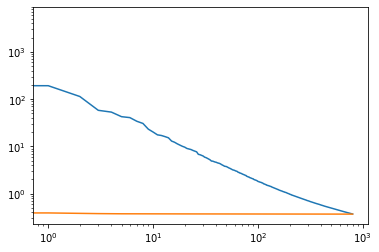

 train loss: 326.5710412 | train acc: 0.9984000 

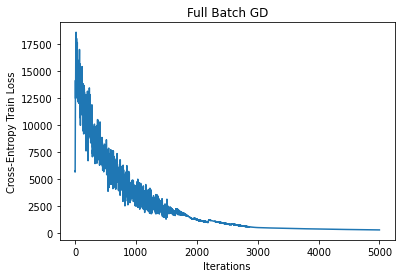

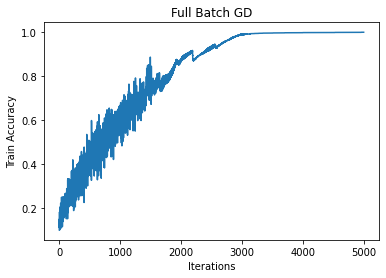

In [0]:
block_size = 2500
k = 800
alpha = train_full_batch(all_data, all_labels, block_size, k)

In [0]:
# Stochastic Coordinate Descent for Kernel Logistic Regression
def eigenpro_sub_update(all_data, all_labels, block_size, eig_block_size, k, num_layers = 2):
    
  # Just-in-time compilation of kernel fn
  get_kernel = jit(lambda X, Xp: kernel(jnp.dot(X, Xp.T), num_layers) )
  get_res = jit(lambda K, alpha, y: y - soft_max(jnp.dot(K, alpha) ) )
  speedy_dot = jit(lambda a, b: jnp.dot(a,b))
  mse = jit(lambda res: jnp.mean(res**2))
  predict = jit(lambda K, alpha: soft_max( jnp.dot(K,alpha)))

  X_s = all_data[0:eig_block_size,:]
  K_s = get_kernel(X_s,X_s)
  w_s, v_s = sp.linalg.eigh(K_s, eigvals = (eig_block_size-1-k,eig_block_size-1))
  w_s = w_s[::-1]
  v_s = v_s[:,::-1]
  plt.loglog(w_s)
  plt.show()

  # Construct preconditioning matrix
  P = speedy_dot(v_s, speedy_dot(np.diag(w_s**(-1)), speedy_dot( (np.eye(k+1) - w_s[-1]*np.diag(w_s**(-1))), v_s.T ) ) )


  wp,vp = sp.linalg.eigh( P @ K_s, eigvals = (eig_block_size-10, eig_block_size-1) )
  T = 1600
  alpha = np.zeros(all_labels.shape)
  eta = 800 / np.amax(wp)
  print("eta = %.6f" %eta)
  train_acc = np.zeros(T)
  
  start_train = timeit.default_timer()
  for t in range(T):
    start = (t * block_size) % all_data.shape[0] 
    X_m = all_data[start:start+block_size,:]
    y_m = all_labels[start:start+block_size,:]
    K_m = get_kernel(X_m, all_data)
    res = get_res(K_m, alpha, y_m)


    sig = predict(K_m, alpha)
    train_loss = - ( y_m* np.log(sig)).mean()
    preds = np.argmax(sig, axis = 1).astype('int')
    true  = np.argmax(y_m, axis =1).astype('int')
    train_acc[t] = (preds==true).mean()

    # break if converged    
    if t > 10 and np.mean(train_acc[t-2:t+1]) > 0.99:
      break

    # otherwise make gradient descent update
    alpha[start:start+block_size,:] += eta/block_size * res
    K2 = get_kernel(X_s,X_m)
    alpha[0:eig_block_size,:] += - eta/block_size * speedy_dot(P, speedy_dot(K2, res))
    
    
    alpha_norm = mse(alpha)
    sys.stdout.write('\r train loss: %.8f | train acc %.8f | alpha norm %.8f' % (train_loss, train_acc[t], alpha_norm) )
  
  train_time = timeit.default_timer() - start_train
  
  print("total training time: %.8f" % train_time)

  return alpha, train_time


# Compute Classification Error
def gen_err_full_data(alpha):
  errs = []
  for i in range( int(all_test_data.shape[0]/block_size) ):
    X = all_test_data[i*block_size:(i+1)*block_size,:] 
    K = kernel_2_layer(X @ all_data.T)
    yhat = K @ alpha
    pred = np.argmax(yhat, axis = 1)
    true = np.argmax(all_test_labels[i*block_size:(i+1)*block_size,:], axis=1)
    errs += [(pred==true).mean()]
  gen_err = np.mean(errs)
  return gen_err

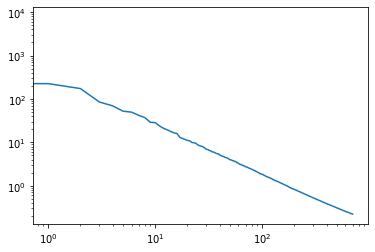

0.22119957
eta = 798.482726
 train loss: 0.01787072 | train acc 0.77200000 | alpha norm 5.46515894total training time: 330.16444851


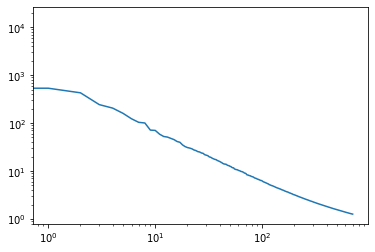

1.2614417
eta = 800.075109
 train loss: 0.00400612 | train acc 0.98850000 | alpha norm 0.59641361total training time: 164.44309789


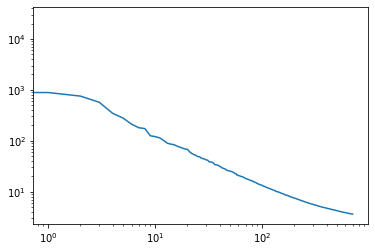

3.6265554
eta = 800.110642
 train loss: 0.00415828 | train acc 0.99550000 | alpha norm 0.04853706total training time: 51.12501071


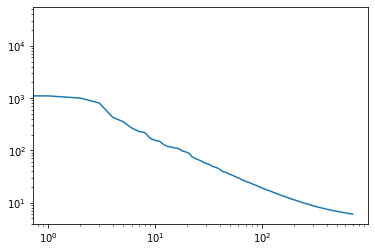

6.049018
eta = 800.129959
 train loss: 0.00435034 | train acc 0.99250000 | alpha norm 0.01419486total training time: 30.96220556


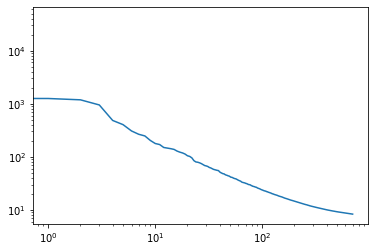

8.30698
eta = 800.156529
 train loss: 0.00308240 | train acc 0.99900000 | alpha norm 0.00766767total training time: 28.19656308


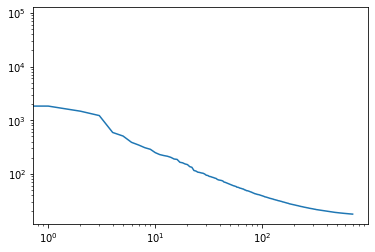

17.862133
eta = 800.173797
 train loss: 0.00261276 | train acc 0.99550000 | alpha norm 0.00156741total training time: 37.13846680


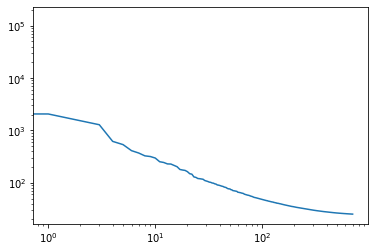

25.266048
eta = 800.138450
 train loss: 0.00035006 | train acc 0.99850000 | alpha norm 0.00149832total training time: 99.88309044


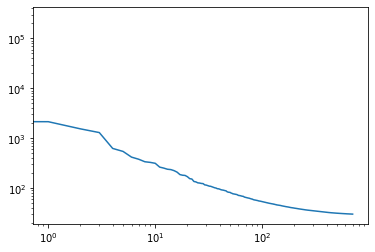

30.121624
eta = 799.928576
 train loss: 0.00012830 | train acc 0.99950000 | alpha norm 0.00148685total training time: 374.46227938


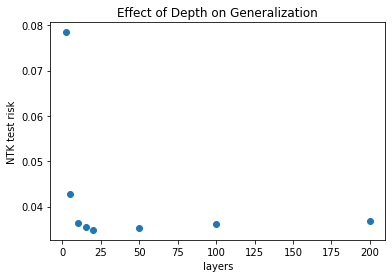

"\nplt.plot(layers, errs, 'o')\nplt.xlabel('layers')\nplt.ylabel('NTK test risk')\nplt.title('Effect of Depth on Generalization')\nplt.savefig('drive/My Drive/depth_vs_gen_classification.pdf')\n"

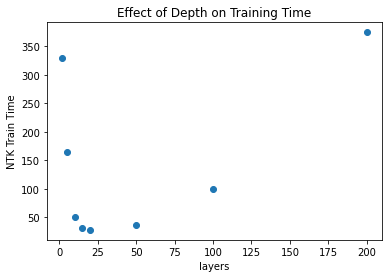

In [0]:
block_size = 2000 # size of minibatch for SGD updates
eig_block_size = 5000 # size of subsample to compute preconditioner
k = 700 # number of eigenvalues to compute
layers = [2,5,10,15,20,50,100, 200] # grid search over depths
errs = []
train_times = []
for i,layer in enumerate(layers):
  alpha, train_time = eigenpro_sub_update(all_data, all_labels, block_size, eig_block_size, k, num_layers = layer)
  errs += [gen_err_full_data(alpha)]
  train_times += [train_time]

# save training time and test error
pd.DataFrame(train_times).to_csv('drive/My Drive/100crossent_loss_train_times_k%d.csv' % k)
pd.DataFrame(errs).to_csv('drive/My Drive/100crossent_loss_gen_k%d.csv' % k)
pd.DataFrame(layers).to_csv('drive/My Drive/100crossent_layer_vals_k%d.csv' % k)

plt.plot(layers, errs, 'o')
plt.xlabel('layers')
plt.ylabel('NTK test risk')
plt.title('Effect of Depth on Generalization')
plt.savefig('drive/My Drive/100depth_vs_gen_class.pdf')
plt.show()

plt.plot(layers, train_times, 'o')
plt.xlabel('layers')
plt.ylabel('NTK Train Time')
plt.title('Effect of Depth on Training Time')
plt.savefig('drive/My Drive/100depth_vs_train_class.pdf')


"""
plt.plot(layers, errs, 'o')
plt.xlabel('layers')
plt.ylabel('NTK test risk')
plt.title('Effect of Depth on Generalization')
plt.savefig('drive/My Drive/depth_vs_gen_classification.pdf')
"""